C:\Users\Lenovo\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


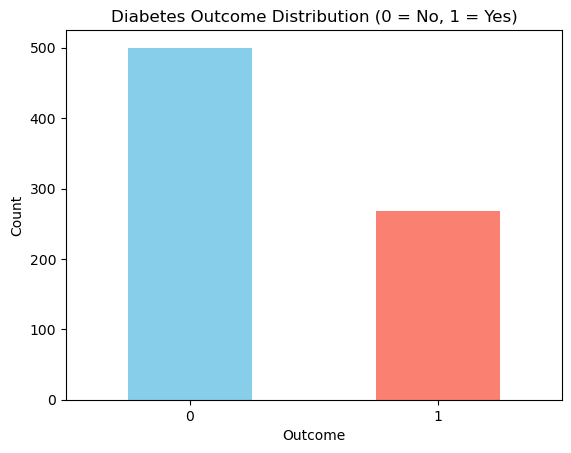

C:\Users\Lenovo\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sqlite3
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.metrics import accuracy_score
import tkinter as tk
from tkinter import messagebox, ttk

# -------------------------
# Database Setup
# -------------------------
conn = sqlite3.connect("diabetes_data.db")
cursor = conn.cursor()

cursor.execute("""
CREATE TABLE IF NOT EXISTS predictions (
    id INTEGER PRIMARY KEY AUTOINCREMENT,
    Pregnancies REAL,
    Glucose REAL,
    BloodPressure REAL,
    SkinThickness REAL,
    Insulin REAL,
    BMI REAL,
    DiabetesPedigreeFunction REAL,
    Age REAL,
    Result TEXT
)
""")
conn.commit()

def save_to_db(data):
    cursor.execute("""
    INSERT INTO predictions 
    (Pregnancies, Glucose, BloodPressure, SkinThickness, Insulin, BMI, DiabetesPedigreeFunction, Age, Result)
    VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?)
    """, data)
    conn.commit()

def view_history():
    history_window = tk.Toplevel(root)
    history_window.title("Prediction History")
    history_window.geometry("900x400")

    tree = ttk.Treeview(history_window, columns=("Pregnancies", "Glucose", "BloodPressure",
                                                 "SkinThickness", "Insulin", "BMI", "DiabetesPedigreeFunction",
                                                 "Age", "Result"), show="headings")

    for col in tree["columns"]:
        tree.heading(col, text=col)
        tree.column(col, width=100)

    cursor.execute("SELECT * FROM predictions")
    rows = cursor.fetchall()
    for row in rows:
        tree.insert("", tk.END, values=row[1:])  # skip ID

    tree.pack(fill="both", expand=True)


# -------------------------
# Load and prepare data
# -------------------------
diabetes = pd.read_csv('diabetes.csv')

x = diabetes.drop(columns='Outcome', axis=1)
y = diabetes['Outcome']

scaler = StandardScaler()
x = scaler.fit_transform(x)

x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, stratify=y, random_state=2
)

classifier = svm.SVC(kernel='linear')
classifier.fit(x_train, y_train)

train_acc = accuracy_score(classifier.predict(x_train), y_train)
test_acc = accuracy_score(classifier.predict(x_test), y_test)


# -------------------------
# Prediction Function
# -------------------------
def predict_diabetes():
    try:
        input_data = [
            float(entry_preg.get()), float(entry_glu.get()), float(entry_bp.get()),
            float(entry_skin.get()), float(entry_insulin.get()),
            float(entry_bmi.get()), float(entry_dpf.get()), float(entry_age.get())
        ]

        input_data_reshaped = np.array(input_data).reshape(1, -1)
        std_data = scaler.transform(input_data_reshaped)
        prediction = classifier.predict(std_data)

        result = "Not Diabetic" if prediction[0] == 0 else "Diabetic"

        save_to_db(input_data + [result])  # Save into database

        if prediction[0] == 0:
            messagebox.showinfo("Result", "✅ The person is NOT diabetic")
        else:
            messagebox.showwarning("Result", "⚠️ The person IS diabetic")

    except ValueError:
        messagebox.showerror("Error", "Please enter valid numbers.")


# -------------------------
# Visualization Functions
# -------------------------
def show_outcome_distribution():
    diabetes['Outcome'].value_counts().plot(kind='bar', color=['skyblue', 'salmon'])
    plt.title("Diabetes Outcome Distribution (0 = No, 1 = Yes)")
    plt.xlabel("Outcome")
    plt.ylabel("Count")
    plt.xticks(rotation=0)
    plt.show()

def show_glucose_vs_age():
    plt.scatter(
        diabetes['Age'], diabetes['Glucose'],
        c=diabetes['Outcome'], cmap='coolwarm', edgecolors='k'
    )
    plt.title("Glucose vs Age (Colored by Outcome)")
    plt.xlabel("Age")
    plt.ylabel("Glucose")
    plt.colorbar(label="Outcome")
    plt.show()

def show_accuracy_chart():
    plt.bar(['Train Accuracy', 'Test Accuracy'], [train_acc, test_acc],
            color=['blue', 'orange'])
    plt.ylim(0, 1)
    plt.title("Model Accuracy")
    plt.ylabel("Accuracy")
    plt.show()


# -------------------------
# GUI Layout
# -------------------------
root = tk.Tk()
root.title("Diabetes Prediction System 🩺")
root.geometry("420x650")
root.resizable(False, False)

labels = ["Pregnancies", "Glucose", "Blood Pressure", "Skin Thickness",
          "Insulin", "BMI", "Diabetes Pedigree Function", "Age"]

entries = []
for label_text in labels:
    label = tk.Label(root, text=label_text, font=("Arial", 10))
    label.pack()
    entry = tk.Entry(root, width=20, font=("Arial", 10))
    entry.pack()
    entries.append(entry)

(entry_preg, entry_glu, entry_bp, entry_skin,
 entry_insulin, entry_bmi, entry_dpf, entry_age) = entries

btn_predict = tk.Button(root, text="Predict Diabetes", font=("Arial", 12, "bold"),
                        bg="green", fg="white", command=predict_diabetes)
btn_predict.pack(pady=10)

btn_history = tk.Button(root, text="📜 View Prediction History", bg="purple", fg="white",
                        command=view_history)
btn_history.pack(pady=5)

btn1 = tk.Button(root, text="📊 Outcome Distribution", command=show_outcome_distribution)
btn1.pack(pady=5)

btn2 = tk.Button(root, text="🔵 Glucose vs Age", command=show_glucose_vs_age)
btn2.pack(pady=5)

btn3 = tk.Button(root, text="📈 Accuracy Chart", command=show_accuracy_chart)
btn3.pack(pady=5)

btn_exit = tk.Button(root, text="Exit", command=root.destroy, bg="red", fg="white")
btn_exit.pack(pady=10)

root.mainloop()

# Close DB connection when app ends
conn.close()
